In [6]:
from methods import *
from L_calc import *

import pandas as pd
import matplotlib.pyplot as plt

In [7]:
from models.LeNet import *
mnist = LeNet("models/lenet_mnist_model.pth")
mnist_model = target_lenet.model
mnist_device = target_lenet.device
mnist_test_loader = target_lenet.testloader

from models.simple_FashionMNIST import *
fmnist = simple_FashionMNIST("models/simple_FashionMNIST.pth")
fmnist_model = fmnist.model
fmnist_device = fmnist.device
fmnist_test_loader = fmnist.testloader

from models.resNet import ResNet20
cifar10 = ResNet20()
cifar10_model = cifar10.model
cifar10_device = cifar10.device
cifar10_test_loader = cifar10.testloader

# L_constants [6.701272487640381, 19.250612258911133, 3.085362672805786]

Running on cpu.
Model weights loaded successfully


Using cache found in C:\Users\alepa/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Files already downloaded and verified


In [8]:
fw_iters = [15]
eps = 0.03
hist = None
debug = True


all_algos = ['fsgm', 'pgd', 
             'fw', 'fw_momentum', 'fw_l1', 'fw_l2', 'fw_p2', 
             'fw_away', 'fw_away_l1', 'fw_away_l2', 'fw_away_p2',
             'fw_pair', 'fw_pair_l1', 'fw_pair_l2', 'fw_pair_p2']

all_stepsizes = ['fixed', 'decay', 'ls'] # fix armijo and add it

In [9]:
def history_acc_eps(test_fw, datasets, devices, eps, iterations, method='fw_pair', early_stopping='gap_FW',
            fw_stepsize_rule='fixed', gap_FW_tol=0.1):
    accuracies_dict = {name: [] for name in datasets.keys()}
    examples_dict = {name: [] for name in datasets.keys()}
    all_hist_dict = {name: [] for name in datasets.keys()}
    final_hist_dfs_dict = {name: [] for name in datasets.keys()}
    epsilons = [0.001, 0.005, 0.025, 0.05, 0.1]

    for eps in epsilons:
        for name, dataset in datasets.items():
            device = devices[name]
            # Run the test function with the given parameters
            acc, ex, hist = test_fw(dataset, device, eps, iterations, method=method, early_stopping=early_stopping,
                                    fw_stepsize_rule=fw_stepsize_rule, gap_FW_tol=gap_FW_tol)

            # Collect the results
            accuracies_dict[name].append(acc)
            examples_dict[name].append(ex)
            all_hist_dict[name].append(hist)

            # Group by 'example_idx' and get the last row for each group
            final_hist = hist.groupby('example_idx').tail(1)
            final_hist_dfs_dict[name].append(final_hist)

    # Combine all historical dataframes into one for each dataset
    combined_hist_dfs = {name: pd.concat(all_hist).reset_index(drop=True) for name, all_hist in all_hist_dict.items()}
    combined_final_hist_dfs = {name: pd.concat(final_hist).reset_index(drop=True) for name, final_hist in
                               final_hist_dfs_dict.items()}

    # Display the historical dataframes
    for name, hist_df in combined_hist_dfs.items():
        print(f"Historical DataFrame for {name}")
        display(hist_df)

    # Plot the accuracy per epsilon for each dataset
    plt.figure(figsize=(10, 6))
    for name, accuracies in accuracies_dict.items():
        plt.plot(epsilons, accuracies, marker='o', label=name)
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy')
    plt.title(f'Algorithm: {method}, Stepsize Method: {fw_stepsize_rule}')
    plt.legend()
    plt.grid(True)
    plt.show()


datasets = {'MNIST': mnist, 'FashionMNIST': fmnist, 'CIFAR-10': cifar10}
devices = {'MNIST': mnist_device, 'FashionMNIST': fmnist_device, 'CIFAR-10': cifar10_device}

Dataset model:<models.LeNet.LeNet object at 0x000001A63221D490>	Epsilon: 0.001	Correct Classifications (Failed Attacks) = 992 / 1000 = 0.992
Dataset model:<models.simple_FashionMNIST.simple_FashionMNIST object at 0x000001A62DBFC980>	Epsilon: 0.001	Correct Classifications (Failed Attacks) = 879 / 1000 = 0.879
Dataset model:<models.resNet.ResNet20 object at 0x000001A62F8D71D0>	Epsilon: 0.001	Correct Classifications (Failed Attacks) = 583 / 1000 = 0.583
Dataset model:<models.LeNet.LeNet object at 0x000001A63221D490>	Epsilon: 0.005	Correct Classifications (Failed Attacks) = 984 / 1000 = 0.984
Dataset model:<models.simple_FashionMNIST.simple_FashionMNIST object at 0x000001A62DBFC980>	Epsilon: 0.005	Correct Classifications (Failed Attacks) = 623 / 1000 = 0.623
Dataset model:<models.resNet.ResNet20 object at 0x000001A62F8D71D0>	Epsilon: 0.005	Correct Classifications (Failed Attacks) = 21 / 1000 = 0.021
Dataset model:<models.LeNet.LeNet object at 0x000001A63221D490>	Epsilon: 0.025	Correct Clas

,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.071104,False,False,9,9,gap,0.000000
1,1,1,0.050910,False,False,3,3,gap,0.000000
2,2,1,0.055143,False,False,0,0,gap,0.000000
3,3,1,0.067406,False,False,9,9,gap,0.000000
4,4,1,0.066155,False,False,5,5,gap,0.000000
...,...,...,...,...,...,...,...,...,...
15784,998,2,2.914818,True,True,2,8,None,1.908789
15785,998,3,0.010006,True,False,2,8,gap,0.009202
15786,999,1,6.738174,True,True,2,7,None,0.000000
15787,999,2,0.519813,True,False,2,7,None,0.253737


Historical DataFrame for FashionMNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.964374,False,False,9,9,None,0.000000
1,0,2,0.382317,False,False,9,9,None,0.590578
2,0,3,-0.016278,False,False,9,9,gap,0.977765
3,1,1,0.479053,False,False,2,2,None,0.000000
4,1,2,0.119141,False,False,2,2,None,0.366032
...,...,...,...,...,...,...,...,...,...
17462,999,11,3.652767,True,False,7,9,None,0.414609
17463,999,12,3.652767,True,False,7,9,None,0.414609
17464,999,13,3.652767,True,False,7,9,None,0.414609
17465,999,14,3.652767,True,False,7,9,None,0.414609


Historical DataFrame for CIFAR-10


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,1.008473,False,False,0,0,None,0.000000e+00
1,0,2,0.180556,False,False,0,0,None,8.011006e-01
2,0,3,-0.324042,False,False,0,0,gap,1.239348e+00
3,1,1,0.566880,False,False,0,0,None,0.000000e+00
4,1,2,0.189923,False,False,0,0,None,3.058368e-01
...,...,...,...,...,...,...,...,...,...
16973,997,2,0.002166,True,False,7,2,gap,9.909180e-05
16974,998,1,153.525146,True,True,8,2,None,0.000000e+00
16975,998,2,0.000393,True,False,8,2,gap,-9.095626e-08
16976,999,1,105.398651,True,True,4,2,None,0.000000e+00


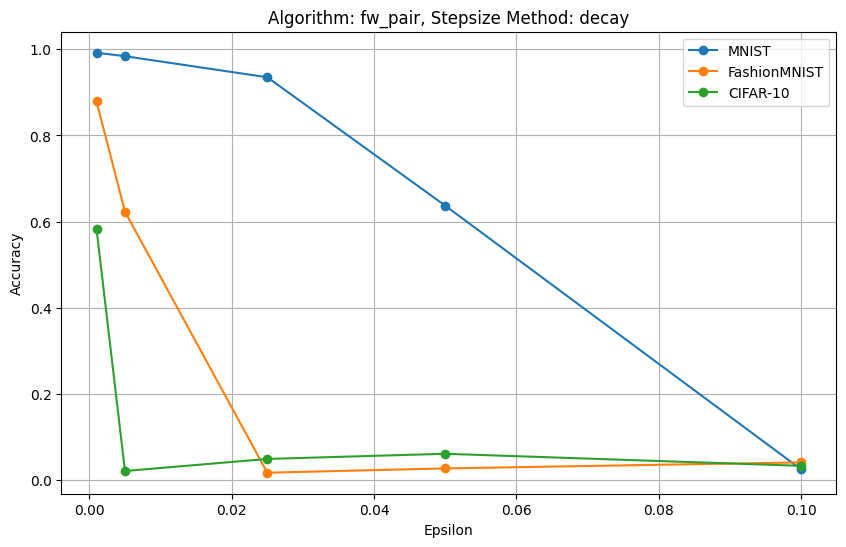

In [10]:
history_acc_eps(test_fw, datasets, devices, eps, 15, method='fw_pair', early_stopping='gap_FW', fw_stepsize_rule='decay',
        gap_FW_tol=0.1)